In [1]:
from typing import Any
from collections.abc import Iterable


import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from abc import ABC, abstractmethod
import pydantic
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/nazarlenisin/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nazarlenisin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nazarlenisin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nazarlenisin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# common_texts
# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
# models = gensim.downloader.info()['models']
# glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
# model.wv.most_similar('trees', topn=10)
# model.wv.similarity('trees', 'graph')
# model.wv.distance('trees', 'graph')
# model.wv.wmdistance(['trees'], ['graph'])

Task 1

In [3]:
class TextPreprocessorI(ABC):
    @staticmethod
    @abstractmethod
    def preprocess(text: str) -> list[str]:
        ...
        
class TextPreprocessor:
    @staticmethod
    def preprocess(text: str) -> list[str]:
        return word_tokenize(text)

In [4]:
class MultiDocumentWordToVec(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)
    
    vector_size: int = pydantic.Field(default=100)
    window: int = pydantic.Field(default=5)
    min_count: int = pydantic.Field(default=5)
    workers: int = pydantic.Field(default=4)
    text_preprocessor: TextPreprocessorI = pydantic.Field(default_factory=TextPreprocessor)
    is_fit: bool = pydantic.Field(default=False)
    
    def __repr__(self):
        return f'MultiDocumentWordToVec(vector_size={self.vector_size}, window={self.window}, text_preprocessor={self.text_preprocessor.__class__.__name__}, is_fit={self.is_fit})'
    
    @staticmethod
    def _check_document(document: Any):
        if not isinstance(document, str):
            raise TypeError('All docoments has to be of type string')
        
    @staticmethod
    def _check_documents(documents: Any):
        if not isinstance(documents, list):
            raise TypeError('Input documents has to be stored in list.')
        
    @staticmethod
    def _check_if_fit(obj: 'MultiDocumentWordToVec'):
        if not obj.is_fit:
            raise ValueError('Fit model first.')
    
    @classmethod
    def _preprocess_documents(cls, text_preprocessor: TextPreprocessorI, documents: list[str]) -> list[list[str]]:
        preprocessed_documents = []
        
        for document in documents:
            cls._check_document(document)
            preprocessed_documents.append(text_preprocessor.preprocess(document))
        logging.info('Documents has been preprocessed successfully.')
        return preprocessed_documents
    
    @staticmethod
    def _get_document_vector(document: list[str], vector_size: int, model: Word2Vec) -> np.ndarray:
        document_vector = np.zeros(vector_size)
        for token in document:
            document_vector += model.wv[token] if token in model.wv else np.zeros(vector_size)
        logging.info('Document vector has been calculated successfully.')
        return document_vector / len(document)
    
    def _get_documents_vectors(
        self, 
        documents: list[list[str]], 
        vector_size: int, 
        model: Word2Vec
        ) -> list[np.ndarray]:
        documents_vectors = []
        labels = []
        for document in documents:
            documents_vectors.append(self._get_document_vector(document, vector_size, model))
        logging.info('Documents vectors has been calculated successfully.')
        return documents_vectors
    
    def _dimensionality_reduction(
        self, 
        documents_vectors: list[np.ndarray], 
        n_components: int = 2, 
        random_state: int = 42
        ) -> list[np.ndarray]:
        self._dimensionality_reduction_model = PCA(n_components=n_components, random_state=random_state)
        reduced_document_vector = self._dimensionality_reduction_model.fit_transform(np.array(documents_vectors))
        logging.info('Dimensionality reduction done successfully.')
        return reduced_document_vector
    
    def visualize_document_distances(self, documents: list[str], figsize: tuple[int, int] = (10,6)) -> None:
        self._check_documents(documents)
        self._check_if_fit(self)
        preprocessed_documents = self._preprocess_documents(self.text_preprocessor, documents)
        documents_vectors = self._get_documents_vectors(preprocessed_documents, 
                                                        self.vector_size, 
                                                        self._model)
        
        plt.figure(figsize=figsize)
        for document_idx, document_vector in enumerate(documents_vectors):
            plt.scatter(document_vector[0], document_vector[1], color='purple')
            plt.annotate(f'doc. {document_idx}', (document_vector[0], document_vector[1]), 
                         textcoords='offset points', ha='center')
        plt.title("Document similarity via average Word2Vec embeddings")
        plt.xlabel('PCA0')
        plt.ylabel('PCA1')
        plt.show()
        
    def fit(self, documents: list[str]):
        self._check_documents(documents)
        preprocess_documents = self._preprocess_documents(self.text_preprocessor, documents)
        self._model = Word2Vec(sentences=preprocess_documents, vector_size=100, window=5, workers=4)
        self.is_fit = True
        logging.info('Word2Vec has been trained successfully.')
        
    @property
    def word_to_vec_model(self):
        return self._model if self.is_fit else None

In [5]:
documents = [gutenberg.raw(document) for document in gutenberg.fileids()]
custom_word_to_vec = MultiDocumentWordToVec()
custom_word_to_vec.fit(documents)
model = custom_word_to_vec.word_to_vec_model

In [6]:
print("Similarity between 'love' and 'affection':", model.wv.similarity('love', 'affection'))
print("Most similar to 'king':", model.wv.most_similar('king'))


Similarity between 'love' and 'affection': 0.8352314
Most similar to 'king': [('Noah', 0.997798502445221), ('fiery', 0.9976187348365784), ('three', 0.9975102543830872), ('sky', 0.9975067377090454), ('broke', 0.9970910549163818), ('tall', 0.9967200756072998), ('bag', 0.9967123866081238), ('cross', 0.9965200424194336), ('gold', 0.9963542819023132), ('red', 0.996216356754303)]


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_84667/327183613.py:82: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f'doc. {document_idx}', (document_vector[0], document_vector[1]),


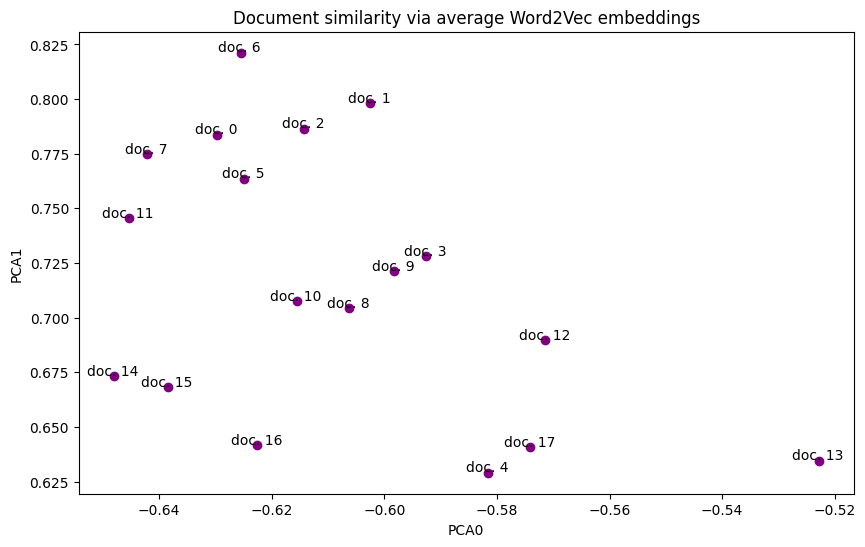

In [7]:
custom_word_to_vec.visualize_document_distances(documents)

In [8]:
wordsim_path = datapath("wordsim353.tsv")
glove_vectors = api.load('glove-wiki-gigaword-100')

spearman_own, pearson_own, oov_ration_own = model.wv.evaluate_word_pairs(wordsim_path)
print('Custom Word2Vec model: ')
print(f"Spearman rank-order correlation coefficient: {spearman_own.correlation}")
print(f"Pearson correlation coefficient: {pearson_own.correlation}")
print(f"OOV Ration: {oov_ration_own}")
print()

spearman_glove, pearson_glove, oov_ration_glove = glove_vectors.evaluate_word_pairs(wordsim_path)
print('Pretrained GloVe model: ')
print(f"Spearman rank-order correlation coefficient: {spearman_glove.correlation}")
print(f"Pearson correlation coefficient: {pearson_glove.correlation}")
print(f"OOV Ration: {oov_ration_glove}")

Custom Word2Vec model: 
Spearman rank-order correlation coefficient: 0.003652783558260765
Pearson correlation coefficient: 0.010267033304608526
OOV Ration: 49.57507082152974

Pretrained GloVe model: 
Spearman rank-order correlation coefficient: 0.5483502231756461
Pearson correlation coefficient: 0.5327354323238274
OOV Ration: 0.0
